INSTALL REQUIRED PACKAGES

In [ ]:
!pip install ultralytics
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

CLONE THE DATASET FROM GITHUB

In [ ]:
!git clone https://github.com/Sourajit-Maity/juvdv2-vdvwc.git

Cloning into 'juvdv2-vdvwc'...
remote: Enumerating objects: 5613, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 5613 (delta 0), reused 0 (delta 0), pack-reused 5571
Receiving objects: 100% (5613/5613), 538.71 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (5626/5626), done.


IMPORT LIBRARIES

In [ ]:
import os
import shutil
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from ultralytics import YOLO
from tqdm import tqdm
from PIL import Image

DEFINE PATHS AND OUTPUT DIRECTORIES

In [ ]:
root_dir = "/content/juvdv2-vdvwc"
train_imgs_dir = os.path.join(root_dir, "Train")
val_imgs_dir = os.path.join(root_dir, "Val")
annotations_dir = os.path.join(root_dir, "Annotation")
output_root_dir = "/content/data"

SETUP DIRECTORIES

In [ ]:
def setup_directories(root_dir):
    os.makedirs(os.path.join(root_dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "labels/val"), exist_ok=True)

setup_directories(output_root_dir)

COUNT THE JPG AND JPEG FILES

In [ ]:
def count_image_extensions(root_dir):
    jpg_count = 0
    jpeg_count = 0

    for split in ["Train", "Val"]:
        for weather in ["Rainny", "Sunny"]:
            for time in ["Day", "Night"]:
                img_dir = os.path.join(root_dir, split, weather, time)
                for img_name in os.listdir(img_dir):
                    if img_name.endswith(".jpg"):
                        jpg_count += 1
                    elif img_name.endswith(".jpeg"):
                        jpeg_count += 1

    return jpg_count, jpeg_count

jpg_count, jpeg_count = count_image_extensions(root_dir)

print(f"Number of .jpg files: {jpg_count}")
print(f"Number of .jpeg files: {jpeg_count}")

Number of .jpg files: 2705
Number of .jpeg files: 95


CONVERT ALL JPEG IMAGES TO JPG IMAGES


In [ ]:
def convert_jpeg_to_jpg(root_dir):
    for split in ["Train", "Val"]:
        for weather in ["Rainny", "Sunny"]:
            for time in ["Day", "Night"]:
                img_dir = os.path.join(root_dir, split, weather, time)
                img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith(".jpeg")]

                for img_name in tqdm(img_names, desc=f"Converting {split}/{weather}/{time}"):
                    img_path = os.path.join(img_dir, img_name)
                    img = Image.open(img_path)
                    new_img_path = os.path.join(img_dir, img_name.replace(".jpeg", ".jpg"))
                    img.save(new_img_path, "JPEG")
                    os.remove(img_path)

root_dir = "/content/juvdv2-vdvwc"
convert_jpeg_to_jpg(root_dir)

Converting Train/Rainny/Day: 0it [00:00, ?it/s]
Converting Train/Rainny/Night: 0it [00:00, ?it/s]
Converting Train/Sunny/Day: 100%|██████████| 95/95 [00:00<00:00, 228.21it/s]
Converting Train/Sunny/Night: 0it [00:00, ?it/s]
Converting Val/Rainny/Day: 0it [00:00, ?it/s]
Converting Val/Rainny/Night: 0it [00:00, ?it/s]
Converting Val/Sunny/Day: 0it [00:00, ?it/s]
Converting Val/Sunny/Night: 0it [00:00, ?it/s]


RECHECK THE COUNT OF JPG AND JPEG FILES

In [ ]:
jpg_count, jpeg_count = count_image_extensions(root_dir)

print(f"Number of .jpg files: {jpg_count}")
print(f"Number of .jpeg files: {jpeg_count}")

Number of .jpg files: 2800
Number of .jpeg files: 0


PREPARE DATASET FOR TRAINING

In [ ]:
def prepare_dataset(image_root_dir, annotation_root_dir, output_dir):
    for split in ["Train", "Val"]:
        for weather in ["Rainny", "Sunny"]:
            for time in ["Day", "Night"]:
                img_dir = os.path.join(image_root_dir, split, weather, time)
                ann_dir = os.path.join(annotation_root_dir, split, weather, time)
                subset = "train" if split == "Train" else "val"

                img_output_dir = os.path.join(output_dir, "images", subset)
                label_output_dir = os.path.join(output_dir, "labels", subset)

                for img_name in os.listdir(img_dir):
                    if img_name.endswith(".jpg"):
                        img_path = os.path.join(img_dir, img_name)
                        shutil.copy(img_path, img_output_dir)

                        ann_name = img_name.replace(".jpg", ".txt")
                        ann_path = os.path.join(ann_dir, ann_name)
                        if os.path.exists(ann_path):
                            shutil.copy(ann_path, label_output_dir)

prepare_dataset(root_dir, annotations_dir, output_root_dir)

CREATE THE .YAML FILE

In [ ]:
classes = [
    "car", "bike", "auto", "rickshaw", "cycle", "bus", "minitruck",
    "truck", "van", "taxi", "motorvan", "toto", "train",
    "boat", "cycle van"
]

yolo_format = {
    "path": output_root_dir,
    "train": os.path.join(output_root_dir, "images/train"),
    "val": os.path.join(output_root_dir, "images/val"),
    "nc": len(classes),
    "names": {i: name for i, name in enumerate(classes)}
}

with open('/content/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

VALIDATE THE DATASET FOR INCONSISTENCIES AND FIND THE NUMBER OF INSTANCES OF EACH CLASS

In [ ]:
def validate_data(data_path):
    try:
        with open(data_path, 'r') as file:
            data = yaml.safe_load(file)
        return True
    except Exception as e:
        print(f"Data validation error: {e}")
        return False

def validate_annotations(annotation_dir):
    class_counts = {cls: 0 for cls in classes}

    for root, _, files in os.walk(annotation_dir):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            print(f"Invalid annotation format in file {file}: {line}")
                            return False, class_counts
                        class_id, x_center, y_center, width, height = parts
                        if not (0 <= int(class_id) < len(classes)):
                            print(f"Invalid class ID {class_id} in file {file}")
                            return False, class_counts
                        if not (0 <= float(x_center) <= 1 and 0 <= float(y_center) <= 1 and 0 <= float(width) <= 1 and 0 <= float(height) <= 1):
                            print(f"Invalid bounding box values in file {file}: {line}")
                            return False, class_counts
                        class_counts[classes[int(class_id)]] += 1

    return True, class_counts

data_path = "/content/yolo.yaml"
annotations_dir = "/content/data/labels"

if not validate_data(data_path):
    print(f"Invalid data at {data_path}. Please check your dataset.")
else:
    is_valid, class_counts = validate_annotations(annotations_dir)
    if not is_valid:
        print(f"Invalid annotations in {annotations_dir}. Please check your annotation files.")
    else:
        print("Data and annotations are valid.")
        print("Class counts:")
        for cls, count in class_counts.items():
            print(f"{cls}: {count}")

Data and annotations are valid.
Class counts:
car: 10890
bike: 2504
auto: 1080
rickshaw: 1195
cycle: 337
bus: 439
minitruck: 389
truck: 390
van: 364
taxi: 325
motorvan: 9
toto: 162
train: 2
boat: 166
cycle van: 45


TRAIN THE MODEL

In [ ]:
model = YOLO('yolov8x.pt')
model.train(data="/content/yolo.yaml", epochs=30, patience=5, batch=8, lr0=0.0005, imgsz=640, plots=True)

100%|██████████| 131M/131M [00:00<00:00, 363MB/s]


Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/yolo.yaml, epochs=30, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/data/labels/train.cache... 2600 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2600/2600 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/data/images/train/rainy day (236).jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.92G      1.806      1.583      1.404         60        640: 100%|██████████| 325/325 [03:44<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [00:03<00:02,  1.88it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

                   all        200       1199      0.419      0.214      0.283       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.42G      1.834      1.349      1.465         97        640: 100%|██████████| 325/325 [03:36<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]

                   all        200       1199      0.573      0.299      0.411      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.74G       1.85      1.297       1.47         47        640: 100%|██████████| 325/325 [03:35<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        200       1199      0.288      0.292      0.234     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.41G      1.806      1.252      1.459        134        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


                   all        200       1199      0.432       0.34      0.374      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.66G      1.794       1.15      1.452        104        640: 100%|██████████| 325/325 [03:35<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]

                   all        200       1199      0.512      0.362      0.446      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.45G      1.747      1.098       1.42        107        640: 100%|██████████| 325/325 [03:35<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


                   all        200       1199      0.562      0.427      0.457      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.45G      1.737      1.044      1.405         88        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]

                   all        200       1199      0.615      0.399      0.442      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.41G      1.722      1.024      1.407         83        640: 100%|██████████| 325/325 [03:35<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


                   all        200       1199      0.674      0.456      0.486      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.43G      1.702     0.9877      1.392        116        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]

                   all        200       1199       0.53      0.406       0.42      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.42G      1.675     0.9336      1.368         72        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]

                   all        200       1199      0.539      0.476      0.511      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.43G      1.658      0.915      1.357         86        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]

                   all        200       1199      0.568      0.427      0.506      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.41G       1.64     0.8809      1.356         86        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


                   all        200       1199      0.636      0.345       0.44      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.69G      1.627     0.8575      1.347        107        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

                   all        200       1199      0.536       0.47      0.504      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.43G      1.615     0.8453      1.336         80        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


                   all        200       1199      0.664      0.458      0.507      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.45G      1.584     0.8183      1.312         66        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]

                   all        200       1199      0.628      0.427      0.475      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.45G      1.579     0.7965      1.316        133        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

                   all        200       1199      0.623      0.432      0.503       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.48G      1.562     0.7775      1.299        102        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]

                   all        200       1199      0.654      0.433      0.486      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.45G      1.546     0.7587      1.293         82        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

                   all        200       1199      0.668      0.428      0.488      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.43G      1.528      0.749      1.283         89        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

                   all        200       1199      0.771       0.39      0.527      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.41G      1.509     0.7211      1.268        127        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        200       1199      0.648       0.43      0.489      0.245


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.66G      1.534     0.6858      1.306         51        640: 100%|██████████| 325/325 [03:34<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        200       1199       0.71      0.435      0.524      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.43G      1.516     0.6709      1.299         48        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


                   all        200       1199      0.685      0.459      0.534      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.44G      1.502     0.6518      1.286         41        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

                   all        200       1199      0.615      0.452      0.511      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.42G      1.475     0.6384      1.267        102        640: 100%|██████████| 325/325 [03:33<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        200       1199      0.648       0.46      0.529       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       7.4G      1.467     0.6289      1.271         41        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


                   all        200       1199       0.66      0.455       0.53      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       7.4G      1.446      0.612       1.26         67        640: 100%|██████████| 325/325 [03:36<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]

                   all        200       1199      0.736      0.465      0.529      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.44G      1.426     0.5932      1.253         34        640: 100%|██████████| 325/325 [03:34<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


                   all        200       1199      0.671      0.469      0.563      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       7.4G      1.406     0.5806      1.239         63        640: 100%|██████████| 325/325 [03:33<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        200       1199      0.646       0.47      0.541      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.66G      1.391     0.5754      1.229         41        640: 100%|██████████| 325/325 [03:35<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        200       1199      0.672      0.445      0.525      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.43G      1.373     0.5592       1.22         29        640: 100%|██████████| 325/325 [03:36<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

                   all        200       1199       0.65      0.479      0.538      0.272



30 epochs completed in 2.072 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,138,013 parameters, 0 gradients, 257.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


                   all        200       1199       0.67       0.47      0.563      0.281
                   car        159        743      0.786      0.847      0.859       0.42
                  bike         99        125      0.691      0.696      0.758      0.413
                  auto         47         60      0.808       0.42      0.522      0.249
                 cycle         29         46      0.432      0.132      0.242     0.0941
                   bus         48         52       0.81      0.769      0.783      0.381
             minitruck         54         58      0.689      0.431      0.426      0.225
                 truck         32         47      0.805      0.553      0.707      0.342
                   van         25         28      0.024     0.0146     0.0636     0.0284
                  taxi         10         10      0.787        0.8       0.85      0.446
                  toto         28         30      0.868     0.0333       0.42      0.214
Speed: 1.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78928f60e920>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.0460

LOAD THE BEST MODEL AND MEASURE MEAN AVERAGE PRECISION ON VALIDATION DATASET

In [ ]:
path_best_weights = "/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)

metrics = model.val()
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,138,013 parameters, 0 gradients, 257.5 GFLOPs


val: Scanning /content/data/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


                   all        200       1199       0.67       0.47      0.563      0.282
                   car        159        743      0.789      0.849      0.858       0.42
                  bike         99        125      0.688      0.696      0.758      0.413
                  auto         47         60      0.808      0.421      0.522       0.25
                 cycle         29         46      0.436      0.135      0.242     0.0921
                   bus         48         52      0.808      0.769      0.783      0.383
             minitruck         54         58      0.688      0.431      0.426       0.23
                 truck         32         47      0.804      0.553      0.707      0.341
                   van         25         28     0.0256     0.0155     0.0635     0.0281
                  taxi         10         10      0.786        0.8       0.85      0.446
                  toto         28         30      0.865     0.0333      0.422      0.215
Speed: 0.5ms preproce

VISUALISE SOME OF THE PREDICTIONS FROM VALIDATION DATASET


image 1/200 /content/data/images/val/night (651).jpg: 384x640 1 car, 4 bikes, 1 cycle, 1 van, 63.3ms
image 2/200 /content/data/images/val/night (652).jpg: 384x640 4 bikes, 1 auto, 1 cycle, 1 van, 61.8ms
image 3/200 /content/data/images/val/night (653).jpg: 384x640 1 car, 4 bikes, 1 cycle, 36.2ms
image 4/200 /content/data/images/val/night (654).jpg: 384x640 3 bikes, 2 cycles, 1 taxi, 36.0ms
image 5/200 /content/data/images/val/night (655).jpg: 384x640 1 car, 3 bikes, 1 auto, 1 cycle, 1 taxi, 36.1ms
image 6/200 /content/data/images/val/night (656).jpg: 384x640 2 bikes, 1 auto, 1 cycle, 1 van, 34.1ms
image 7/200 /content/data/images/val/night (657).jpg: 384x640 2 bikes, 2 vans, 32.6ms
image 8/200 /content/data/images/val/night (658).jpg: 384x640 1 bike, 1 truck, 33.5ms
image 9/200 /content/data/images/val/night (659).jpg: 384x640 1 bike, 1 auto, 1 truck, 1 van, 32.8ms
image 10/200 /content/data/images/val/night (660).jpg: 384x640 1 car, 2 bikes, 1 auto, 1 truck, 33.2ms
image 11/200 /cont

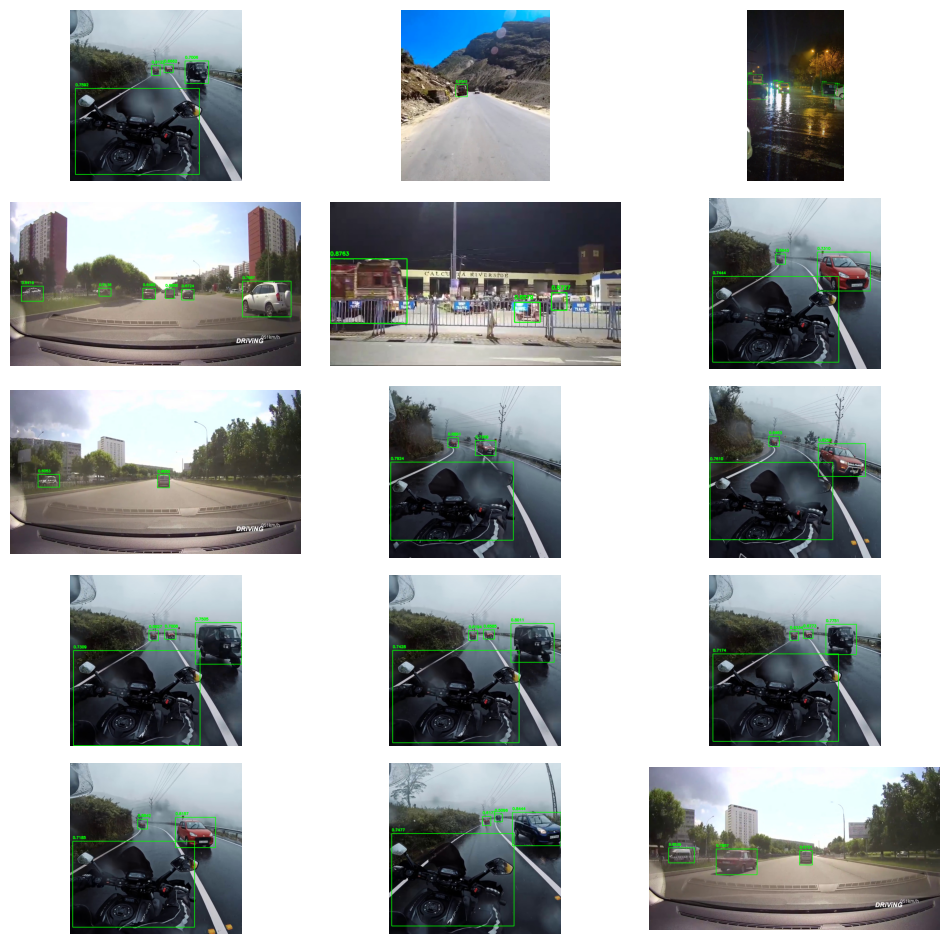

In [ ]:
val_imgs_dir = "/content/data/images/val"
val_labels_dir = "/content/data/labels/val"
prediction_dir = "/content/predictions"

os.makedirs(prediction_dir, exist_ok=True)

model = YOLO('/content/runs/detect/train/weights/best.pt')

with torch.no_grad():
    results = model.predict(source=val_imgs_dir, conf=0.50, iou=0.75)

def show_bbox(img, boxes, scores, axis, color=(0, 255, 0)):
    boxes = boxes.astype(int)
    img = img.copy()
    for i, box in enumerate(boxes):
        score = f"{scores[i]:.4f}"
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        y = box[1] - 10 if box[1] - 10 > 10 else box[1] + 10
        cv2.putText(img, score, (box[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    axis.imshow(img)
    axis.axis("off")

def visualize_predictions(test_imgs_dir, prediction_dir, num_images=15):
    fig, axes = plt.subplots(5, 3, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    ax = axes.flatten()

    test_img_list = [f.split(".")[0] for f in os.listdir(prediction_dir)]
    imgs_name = np.random.choice(test_img_list, num_images)

    for i, img_name in enumerate(imgs_name):
        img_file_path = os.path.join(test_imgs_dir, img_name + ".jpg")
        if not os.path.exists(img_file_path):
            print(f"Image {img_file_path} not found, skipping.")
            continue

        img = cv2.imread(img_file_path)
        if img is None:
            print(f"Failed to read image {img_file_path}, skipping.")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_file_path = os.path.join(prediction_dir, img_name + ".txt")
        label = pd.read_csv(label_file_path, sep=" ", header=None).values
        scores = label[:, 0]
        boxes = label[:, 1:]
        show_bbox(img, boxes, scores, axis=ax[i])

    plt.savefig("predictions.png")
    plt.show()

visualize_predictions(val_imgs_dir, prediction_dir)